## Step 0: Setup & Importing Python Libraries

For this project, we have used the tables from the unofficial Dungeons & Dragons Fifth Edition fandom wiki page.

RAW DATA HERE:
- https://dnd-5e.fandom.com/wiki/Gods


The goal of this project is to analyze the gods and deities in a tabletop roleplaying game Dungeons & Dragons 5th edition's rulebook, and see whether  there are any common patterns with the deities that are created (Popular alignment, popular symbols, popular domains) .


We will be using the following python libraries for this project:
- BeautifulSoup - For pulling data out of HTML files
- Requests - HTTP request simplification
- Pandas - Visualization and transformation of data
- Copy - For copying the rows into the dataframe
- Numpy - Plotting data
- Scipy - Plotting data
- Matplotlib - Plotting data


First, we will import the python libraries listed above.

In [ ]:
# Check if beautifulsoup and pandas are already installed
# If not, install it and then import

try:
    from bs4 import BeautifulSoup
    import pandas
    print ("BeautifulSoup and Pandas are already installed and imported")
except:
    import sys
    !conda install --yes --prefix {sys.prefix} bs4
    !conda install --yes --prefix {sys.prefix} pandas
    from bs4 import BeautifulSoup
    import pandas
    print ("BeautifulSoup and Pandas were not found. Installed them and imported")

import requests
import copy
import numpy as np
import scipy
import matplotlib.pyplot as plt

BeautifulSoup and Pandas are already installed and imported


## Step 1: Data Extraction

In this step, we will be performing ETL (Extract, Transform, Load) with the goal of creating a csv of the data that will be a dataset that anyone can publicly access.

We will begin by first parsing the webpage by using BeautifulSoup.

In [ ]:
opened_webpage = requests.get("https://dnd-5e.fandom.com/wiki/Gods")
print ("Webpage opened successfully!")

# Initialize a BeautifulSoup object to read and parse the webpage read

bs = BeautifulSoup(opened_webpage.content, "html.parser")
print ("Webpage loaded and parsed successfully!")

Webpage opened successfully!
Webpage loaded and parsed successfully!


After the website has been parsed, we will begin the first step of ETL; Extracting the data of interest out of the webpage. The code for this is shown alongside the result below:

In [ ]:
 # Define an empty list where the data will be kept
raw_data = []

# Find all the tables in the webpage page that we have just parsed
table = bs.find_all("table")

for row in table:
    line = row.text
    raw_data.append(line)

print(raw_data)

["\n\nDeity\n\nAlignment\n\nDomains\n\nSymbol\n\n\nAuril, goddess of winter\n\nNE\n\nNature, Tempest\n\nSix-pointed snowflake\n\n\nAzuth, god of wizards\n\nLN\n\nKnowledge\n\nLeft hand pointing upward, outlined in fire\n\n\nBane, god of tyranny\n\nLE\n\nWar\n\nUpright black right hand, thumb and fingers together\n\n\nBeshaba, goddess of misfortune\n\nCE\n\nTrickery\n\nBlack antlers\n\n\nBhaal, god of murder\n\nNE\n\nDeath\n\nSkull surrounded by a ring of blood droplets\n\n\nChauntea, goddess of agriculture\n\nNG\n\nLife\n\nSheaf of grain or a blooming rose over grain\n\n\nCyric, god of lies\n\nCE\n\nTrickery\n\nWhite jawless skull on black or purple sunburst\n\n\nDeneir, god of writing\n\nNG\n\nKnowledge\n\nLit candle above an open eye\n\n\nEldath, goddess of peace\n\nNG\n\nLife, Nature\n\nWaterfall plunging into still pool\n\n\nGond, god of craft\n\nN\n\nKnowledge\n\nToothed cog with four spokes\n\n\nHelm, god of protection\n\nLN\n\nLife, Light\n\nStaring eye on upright left gauntlet\

As can be seen in the printed data, this data needs to be cleaned in order to be used properly in a dataset. As such, we move on to our next step; transformation of the dataset.

First, we can see that the four categories that the data will be sorted is the following:
- Deity
- Alignment
- Domains
- Symbol

To explain to non-DND players, this means the following:
- Deity: The name of the deity
- Alignment: What section of the alignment chart they reside on. For non-dnd players, an explanation on the alignment chart system can be found on the link below:

 https://easydamus.com/alignment.html

- Domains: What concept the deity rules over
- Symbol: The symbol that the deity is associated with

There are also several important things to keep in mind in the transformation process:
- The deities in the Other Faiths of Eberron category includes a fifth column for descriptions. The deities for Wildemount also has five categories, but one for province instead of a description. This will be removed to remain consistent with the dataset.
- The data in Ravnica of the original webpage only have two columns, Guild and Subclass. This are not deities and as such have been removed to remain consistent with the dataset.
- The data in Plane Shift have a deity and domains, but no alignment or symbol. As such, these will have N/A listed in their alignment and domain in the final csv dataset.

We will now start to tranform the dataset with the above in mind. (Specifics to the important things subsection written below)


### Specific mumbo-jumbo on how the important things are going to come into play within the code:

The tables goes through the code normally until the Other Faiths of Eberron table is reached

From there, the program will start its count from 1 and when it reaches a count of 5, will delete that entry and reset the count to one.

This will continue until we reach Avandra, where the deletion count will be changed to every 3rd count.

This will continue until the Theros category, where the appending will resume as normal.

On Ravnica's table, it will count until 4 and on every even count, add N/A to the dictionary.

In [ ]:
# SETUP FOR THE TRANSFORMATION

# column_name_etc has been created to include non-four categories.
column_names = ["Deity", "Alignment", "Domains", "Symbol"]
column_names_all = ["Deity", "Alignment", "Domains", "Symbol", "Province", "Suggested Domains", "Common Symbol", "Warlock Patron", "Guild", "Subclass"]
funky_values = ["The Silver Flame, deity of protection and good", "Avandra", "Asmodeus", "Arms of the Betrayers", "Azorius", "Bontu", "Serra", "Avacyn", "Threefold Sun"]

In order to make sure to account for any irregularities, we will need to know what table the Other Faiths of Eberron, Wildemount, Ravnica, and Plane Shift will be stored in.

We will count how many tables we went through with the int count, and then append the index number to list check.

This will be done below.

In [ ]:
# GETTING THE TABLE INDEX VALUES FOR THE FUNKY TABLES

#These are the values we will need to use in our function.
in_funky = False
count_all = 0
check_funky = []

#Go through each table
for l in raw_data:
    #Splits the specific table by the newlines.
    entries = l.split("\n")

    #Empty dictionary for every row.
    row = {}

    #Go through each entry in the entries.
    for entry in entries:
      #If the entry is one of the tables that needs to have something special done to it, change "in_funky to True."
      if entry in funky_values:
        #print(entry)
        in_funky = True

    #If in_funky is true, add the index value of the count to the list check, then change in_funky to false to make sure it can run correctly again.
    if in_funky:
      check_funky.append(count_all)
      in_funky = False
      #print(entries)

    #Once entire table is run through, add one to count.
    count_all += 1

#Check to make sure the table is correct and I'm not going insane
print(check_funky)

[8, 9, 10, 11, 13, 14, 15, 16, 17]


From the above we can see that tables 8, 9, 10, 11, 13, 14, 15, 16, 17 are the 'funky' tables that need to have a special operation done to them.

### Explanation of what each 'funky' table value is
- 8 is the table with a description in the 5th column
- 9, 10, 11 have a patron/province in the third column
- 13 does not fit with the columns we are looking to analyze and will be deleted
- 14, 15, 16, 17 only have two columns total and need N/A in the alignment chart and symbol row.

Now we will go through and actually start appending the complete data into a dataframe.


** IMPORTANT: If you encounter an error, troubleshoot by putting this code snippet in the entry loop: print(f"{entry} - {temp_count}")

In [ ]:
final_data = []
temp_data = []
count_all = 0
temp_count = 0
check_Once = True

for l in raw_data:
    entries = l.split("\n")
    temp_count = 0



    #Check if the table entries we will look at are "funky" table values.

    if not (count_all in check_funky):
      row = {} # empty dictionary for every row
      #If not funky, go through normally
      for entry in entries:
        #Go through each entry and if the entry is not a newline or part of column_names_all, add to a new list.
        if (entry != "\n") and (entry != " ") and (entry != "")  and ((entry in column_names_all) != True):
        #Add to dictionary. The key is the column name and the value is the entry.
          row[column_names[temp_count]] = entry
          temp_count += 1

          #As there are only 4 columns, when temp count reaches four, it resets to 0.
          if temp_count == 4:
            final_data.append(copy.deepcopy(row))
            #print(final_data)
            temp_count = 0

    elif count_all == 8:
      row = {} # empty dictionary for every row
      for entry in entries:
        #5th value skip
        if (entry != "\n") and (entry != " ") and (entry != "") and ((entry in column_names_all) != True):
          if temp_count == 4:
            final_data.append(copy.deepcopy(row))
            temp_count = 0
            #print(f" 4 - {entry} - {temp_count}")
            #Reset to 0 on 4 count. Skip entry add
            #For those who are confused (me): The original changes temp_count after adding column_names[3], but this one skips the entry for temp_count 4.
            pass

          elif temp_count < 4:
            row[column_names[temp_count]] = entry
            temp_count += 1
            #print(f"before 4 - {entry} - {temp_count}")

      #The code above doesn't include the last value in the table as that one doesn't have a 5th value. We will account for that value with the following code:
      final_data.append(copy.deepcopy(row))

    elif count_all == 9 or count_all == 10 or count_all == 11:
      row = {} # empty dictionary for every row

      #We are using check_Once again to ignore the first **5** values (deity, alignment, province/patron, domain, symbol)
      check_Once = False

      for entry in entries:
        #3rd value skip
        if (entry != "\n") and (entry != " ") and (entry != "")  and ((entry in column_names_all) != True):

          if temp_count == 2:
            #print(f"2 - {entry} - {temp_count}")
            temp_count += 1
            #Skip
            #For those who are confused (me): The 2nd column(3rd value) is the province, which we have no use for. We skip this one.
            #However, because we don't have enough values in column_names, from the 2nd column onwards we do column_names[temp_count-1].
          elif temp_count < 2:
            #print(f"before 2 - {entry} - {temp_count}")
            row[column_names[temp_count]] = entry
            temp_count += 1
          elif 3 <= temp_count <= 4:
            #print(f"3 or 4 - {entry} - {temp_count}")
            row[column_names[temp_count-1]] = entry
            temp_count += 1
          else:
            #Keep going until temp_count reaches 4.
            #print(f"check - {entry} - {temp_count}")
            temp_count += 1

          if temp_count == 5:
            #print(f"5 - {entry} - {temp_count}")
            final_data.append(copy.deepcopy(row))
            temp_count = 0

    elif count_all == 13:
      #Ignore all the values in the 13th table :) 13 is a bad number
      #print("Bad number! Skipping")
      pass

    else:
      row = {} # empty dictionary for every row

      #check_Once test, this time for 2
      check_Once = False

      for entry in entries:
        #Add N/A to temp_count 1 and temp_count 3
        if (entry != "\n") and (entry != " ") and (entry != "")  and ((entry in column_names_all) != True):
          if temp_count < 4:
            print(f"{entry} - {temp_count}")
            row[column_names[temp_count]] = entry
            row[column_names[temp_count + 1]] = "N/A"
            temp_count += 2
            #For those who are confused (me): We add the first entry and then because we have no values on the next entry, we add it as N/A. Because we just put in two entries, we count 2 instead of 1.
          if temp_count == 4:
            print(f"add and replace - {entry} - {temp_count}")
            final_data.append(copy.deepcopy(row))
            temp_count = 0

    count_all += 1


# Sanity check - let's print!
print(final_data[174:])

Bontu - 0
Ambition - 2
add and replace - Ambition - 4
Hazoret - 0
Zeal - 2
add and replace - Zeal - 4
Kefnet - 0
Knowledge - 2
add and replace - Knowledge - 4
Oketra - 0
Solidarity - 2
add and replace - Solidarity - 4
Rhonas - 0
Strength - 2
add and replace - Strength - 4
Serra - 0
Knowledge, Life, Light, War - 2
add and replace - Knowledge, Life, Light, War - 4
The Book of Keld - 0
Forge - 2
add and replace - Forge - 4
Avacyn - 0
Knowledge, Life, War - 2
add and replace - Knowledge, Life, War - 4
Threefold Sun - 0
Life, Light, Nature, Tempest, War - 2
add and replace - Life, Light, Nature, Tempest, War - 4
Aclazotz - 0
Death, Life, War - 2
add and replace - Death, Life, War - 4
[{'Deity': 'Thassa, god of the sea', 'Alignment': 'N', 'Domains': 'Knowledge, Tempest', 'Symbol': 'Waves'}, {'Deity': 'Bontu', 'Alignment': 'N/A', 'Domains': 'Ambition', 'Symbol': 'N/A'}, {'Deity': 'Hazoret', 'Alignment': 'N/A', 'Domains': 'Zeal', 'Symbol': 'N/A'}, {'Deity': 'Kefnet', 'Alignment': 'N/A', 'Domai

Congratulations! You have managed to make a proper dataframe out of the mess that was the spaghetti code above. Let's look at what that dataframe looks like:

In [ ]:
final_data = pandas.DataFrame(final_data)

# Print a few elements in the dataframe
final_data

,Deity,Alignment,Domains,Symbol
0,"Auril, goddess of winter",NE,"Nature, Tempest",Six-pointed snowflake
1,"Azuth, god of wizards",LN,Knowledge,"Left hand pointing upward, outlined in fire"
2,"Bane, god of tyranny",LE,War,"Upright black right hand, thumb and fingers to..."
3,"Beshaba, goddess of misfortune",CE,Trickery,Black antlers
4,"Bhaal, god of murder",NE,Death,Skull surrounded by a ring of blood droplets
...,...,...,...,...
180,Serra,N/A,"Knowledge, Life, Light, War",N/A
181,The Book of Keld,N/A,Forge,N/A
182,Avacyn,N/A,"Knowledge, Life, War",N/A
183,Threefold Sun,N/A,"Life, Light, Nature, Tempest, War",N/A


We will now conduct duplication checks and see if there's any noisy entities that need to be cleaned in the code below.

In [ ]:
#See how many duplicates exist and delete them.
number_of_duplicates = final_data.duplicated().sum()
print (f" Number of duplicates before : {number_of_duplicates}")
final_data = final_data.drop_duplicates()

print("\n")

#See if there are any null entities and remove them.
final_data.info()
final_data = final_data.dropna()

#Print the cleaned data
final_data

 Number of duplicates before : 0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185 entries, 0 to 184
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Deity      185 non-null    object
 1   Alignment  185 non-null    object
 2   Domains    185 non-null    object
 3   Symbol     185 non-null    object
dtypes: object(4)
memory usage: 7.2+ KB


,Deity,Alignment,Domains,Symbol
0,"Auril, goddess of winter",NE,"Nature, Tempest",Six-pointed snowflake
1,"Azuth, god of wizards",LN,Knowledge,"Left hand pointing upward, outlined in fire"
2,"Bane, god of tyranny",LE,War,"Upright black right hand, thumb and fingers to..."
3,"Beshaba, goddess of misfortune",CE,Trickery,Black antlers
4,"Bhaal, god of murder",NE,Death,Skull surrounded by a ring of blood droplets
...,...,...,...,...
180,Serra,N/A,"Knowledge, Life, Light, War",N/A
181,The Book of Keld,N/A,Forge,N/A
182,Avacyn,N/A,"Knowledge, Life, War",N/A
183,Threefold Sun,N/A,"Life, Light, Nature, Tempest, War",N/A


Our data is now clean and ready to go! We will export the data into a csv and upload it on data.world. Link here:
- https://data.world/uthosoyaa/dnd-5e-gods-csv

Code for exporting is written below.

In [ ]:
final_data.to_csv("DnD_Deities_Full_List.csv")

# Step 2: Analyzing the Results

Now that we have our results, we can actually begin the fun part of analyzing the data to see if there are interesting findings.

We'll start by doing some visualizations.

For this project, I specifically wanted to specifically know the frequency of certain domains, alignments, and if any symbols were used more than once. I will be using a bar plot for domain, alignment, and a box plot for the deities. The code used to display the graphs are displayed below:

In [ ]:
#Read the csv into "df"
df = pandas.read_csv('DnD_Deities_Full_List.csv')

N     29
NE    23
CE    22
NG    22
LG    21
LE    17
CG    16
LN    13
CN    12
Name: Alignment, dtype: int64

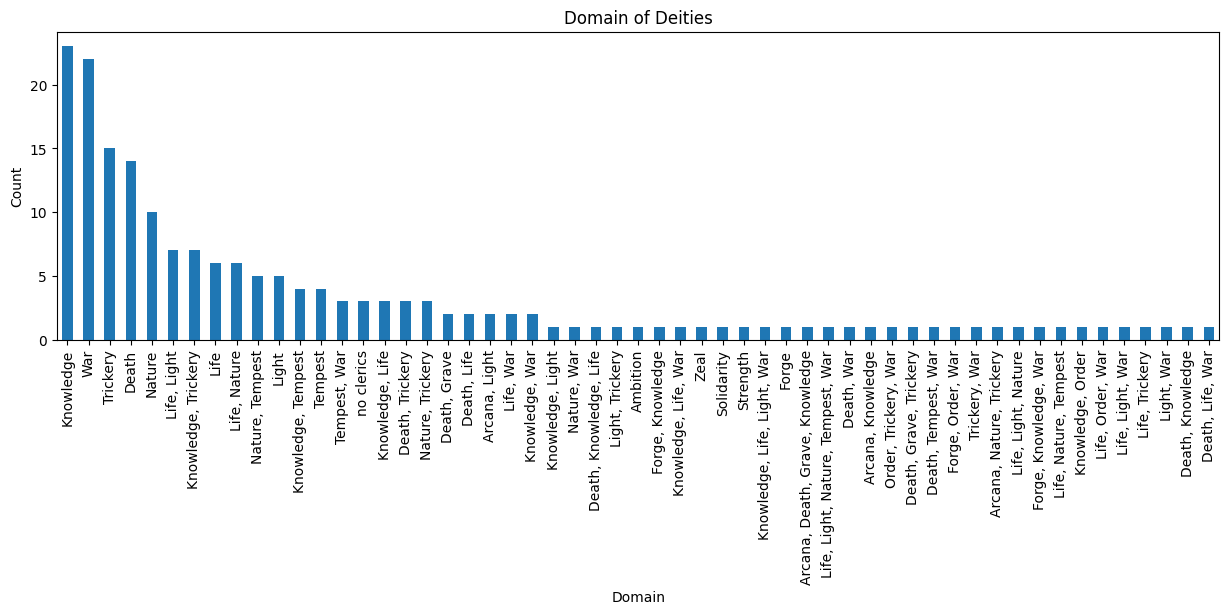

In [ ]:
#Create a bar plot that sees how many counts of times a domain comes up.
df['Domains'].value_counts().plot.bar(figsize=(15, 4),title="Domain of Deities", xlabel = "Domain", ylabel="Count")


#Print out the count of domains.
df['Alignment'].value_counts()


N     29
NE    23
CE    22
NG    22
LG    21
LE    17
CG    16
LN    13
CN    12
Name: Alignment, dtype: int64

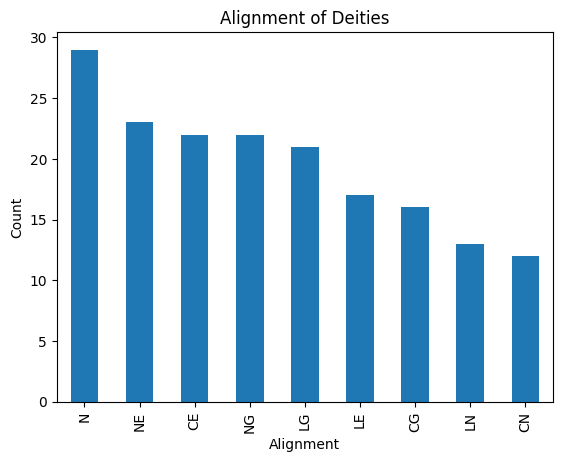

In [ ]:
#Create a bar plot that sees how many counts of times an alignment comes up.
df['Alignment'].value_counts().plot.bar(title="Alignment of Deities", xlabel = "Alignment", ylabel="Count")

#Print out the alignment of deities.
df['Alignment'].value_counts()

Varies                                      3
Crescent moon                               2
Six-pointed snowflake                       1
Dragonshard stone in the shape of a fang    1
Rising sun                                  1
                                           ..
Dragon head with five claw marks            1
Shield                                      1
Green disk                                  1
Eye within a pentagram                      1
Waves                                       1
Name: Symbol, Length: 172, dtype: int64

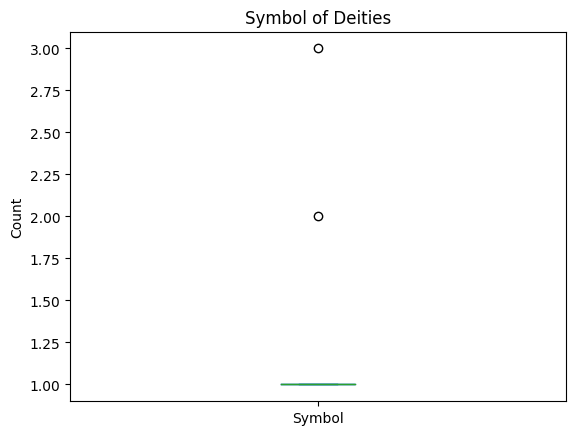

In [ ]:
#Create a box plot to see the frequency of symbols and to see if there are any outliers.
df['Symbol'].value_counts().plot.box(title="Symbol of Deities", ylabel="Count")

#Print out the frequency of symbols that the deities use.
df['Symbol'].value_counts()

## Interesting Findings

Domain
- I'm not surprised at the amount of knowledge, war, and death deities but I expected there to be more for Life and Nature than the final count.

Alignment
- I am surprised to see the alignment least used is CN (Chaotic Neutral), which was what I was expecting most deities to have as their alignment. I think this may be because the deities in D&D5e are much more connected to the players and as such need to have a human-like personality than what I expect out of a deity.

Symbol
- I'm surprised that the crescent moon came up twice, I imagined that there would be much more overlap with other symbols such as the sun or a shield.


 Step 4: Documentation

We will follow best practices for documentation as described in the readings on reproducibility. You need to have documentation in three places: your Jupyter notebook, your README file on GitHub, and with your dataset on data.world.


Your README should include:

    The goal of your project
    Links to any relevant API documentation
    The license of your data and any source data
    A data type and description for each attribute in your data
    Any known issues or potential issues, such as sources of bias in collection

Your dataset at data.world should be accompanied by:

    A project summary that explains your collection, processing and analysis methods as a high level, as well as links to your GitHub repo
    A data dictionary with a data type and description for each attribute in your data

 Step 5: Publication and Submission

Submit your processed data as a CSV file on data.world. Add a brief project description, your project summary, and your data dictionary.

 Create a public GitHub repository for your analysis. Upload your code and data. Add a README and a LICENSE for the repo. The README should include all of your documentation about the data (such as its provenance, any quirks in your data, potential biases, etc.) and the analysis (what you are showing, and why). The LICENSE should be an MIT License

Links to an external site. for your code.

 On Canvas, submit links to your GitHub repo and data.world dataset, as well as the image file of your final visualization.

Tip: someone who stumbles across your GitHub repo should be able to fully reproduce your analysis. In that event, what information would that person want or need? Make sure you include it!

Grading Scheme (Total Points = 15)

[1] Setting up the GitHub repository, clean and concise README with project goals and descriptions mentioned, incorporation of MIT license [2 points]

[3] Clean Data at data.world  with proper project summary and data dictionary definitions [2 points]

[5] Pushing your code (ipynb file) to your GitHub repo properly + code quality [1 point]

Total Points = 15



